In [1]:
import os
import numpy as np
import polars as pl
import matplotlib.pyplot as plt


from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, matthews_corrcoef
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score


from imblearn.under_sampling import RandomUnderSampler


from joblib import parallel_backend


import tensorflow as tf
import tensorflow.keras.backend as K


import emlearn


import pickle


plt.style.use('seaborn-v0_8-paper')
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['lines.linewidth'] = 2

In [2]:
def dataframe_shift(df, columns, windows):
    for i in range(1, windows):
        df = df.with_columns((pl.col(columns).shift(i)).name.prefix(f'prev_{i}_'))
    return df.drop_nulls()

In [3]:
def matthews_correlation_coefficient(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / K.sqrt(den + K.epsilon())

In [4]:
def get_mlp_keras(n_input, n_output):
    keras_mlp = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(n_input,)),
    tf.keras.layers.Dense(64, activation='elu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='elu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(n_output, activation='softmax')
    ])
    
    keras_mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[matthews_correlation_coefficient])

    return keras_mlp

In [5]:
def generate_models(n_input, n_output, light=False):
    # Remove MLP due to low performance and high computional resources
    # The code is present if anyone wants to explore further
    if light:
        models = [
            ('DecisionTreeClassifier', DecisionTreeClassifier(
            max_depth=128, max_features='sqrt', max_leaf_nodes=512, 
            random_state=42, class_weight='balanced')),
            ('RandomForestClassifier', RandomForestClassifier(n_estimators=32,
            max_depth=128, max_features='sqrt', max_leaf_nodes=512, 
            random_state=42, class_weight='balanced')),
            ('ExtraTreesClassifier', ExtraTreesClassifier(n_estimators=32,
            max_depth=128, max_features='sqrt', max_leaf_nodes=512, 
            random_state=42, class_weight='balanced')),
            ('Bagging', BaggingClassifier(n_estimators=32, max_features=0.1, random_state=42))
        ]
    else:
        models = [
            ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=42, class_weight='balanced')),
            ('RandomForestClassifier', RandomForestClassifier(random_state=42,  class_weight='balanced')),
            ('ExtraTreesClassifier', ExtraTreesClassifier(random_state=42, class_weight='balanced')),
            ('Bagging', BaggingClassifier(random_state=42)),
            ('MLP (Keras)', get_mlp_keras(n_input, n_output))
        ]

    return models

In [6]:
def run_models(dfs, unique_labels, fr=None, n_components=0, light=False):
    rv = []
    for df_name, df in dfs:
        with parallel_backend('loky', n_jobs=-1):
            print(f'--- Dataset {df_name} ---')
            Y = df['Class'].to_numpy()
            X = df.drop(['Class', 'Time']).to_numpy()
            
            undersample = RandomUnderSampler(sampling_strategy='not minority', random_state=42)
            X, Y = undersample.fit_resample(X, Y)

            X_train, X_test, y_train, y_test = train_test_split(X, 
            Y, test_size=0.3, random_state=42, stratify=Y)

            # Feature Reduction
            if fr == 'PCA':
                pca = PCA(n_components=n_components)
                pca.fit(X_train)
                X_train = pca.transform(X_train)
                X_test = pca.transform(X_test)
            elif fr == 'NMF':
                nmf = NMF(n_components=n_components, init='nndsvda', solver='mu', max_iter=1000)
                nmf.fit(X_train)
                X_train = nmf.transform(X_train)
                X_test = nmf.transform(X_test)
            
            best = None
            print(f'{"":<22} Accuracy Precision Recall F1-score   MCC')
            # Generate models
            num_classes = len(unique_labels)
            models = generate_models(X_train.shape[1], num_classes, light=light)
            for name, clf in models:
                if name == 'MLP (Keras)':
                    y_train_keras = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
                    y_test_keras = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

                    clf.fit(X_train, y_train_keras,
                    batch_size=2048,
                    epochs=500,
                    verbose=0,
                    validation_data=(X_test, y_test_keras))

                    y_pred = clf.predict(X_test, verbose=0)
                    y_pred = np.argmax(y_pred, axis=1)
                else:
                    clf.fit(X_train, y_train)
                    y_pred = clf.predict(X_test)
                
                acc = accuracy_score(y_test, y_pred)
                mcc = matthews_corrcoef(y_test, y_pred)
                f1 = f1_score(y_test, y_pred, average='weighted')
                recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
                precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
                print(f'{name:<22} {acc:>8.2f} {precision:>9.2f} {recall:>6.2f} {f1:>8.2f} {mcc:>5.2f}')

                if best is None:
                    best = (mcc, clf, name, y_test, y_pred)
                else:
                    if mcc > best[0]:
                        best = (mcc, clf, name, y_test, y_pred)
        _, clf, name, y_test, y_pred = best
        rv.append(clf)
        # print(f'')
        # print(f'Confusion Matrix for the best performing model: {name}')
        # cf_matrix = confusion_matrix(y_test, y_pred)
        # normalized_cf_matrix = cf_matrix / np.sum(cf_matrix)
        # scaled_cf_matrix = normalized_cf_matrix * 8  # Scale to 100%
        
        # cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=scaled_cf_matrix,
        #                                              display_labels=unique_labels)
        # cm_display.plot(values_format='.2%', colorbar=False, cmap='Blues')
        # plt.show()
        return rv

Load data

In [7]:
import os
import polars as pl
import numpy as np
from sklearn.preprocessing import minmax_scale

def process_training_files(file_list, data_path='data/train'):
    """
    Process the training files and return a concatenated dataframe
    """
    # Initialize variables to store global min and max values
    global_min_x, global_max_x = float('inf'), float('-inf')
    global_min_y, global_max_y = float('inf'), float('-inf')
    global_min_z, global_max_z = float('inf'), float('-inf')
    
    dfs = []
    for dataset in file_list:
        df = pl.read_csv(f'{data_path}/{dataset}', separator=';').with_columns(
            pl.from_epoch('Time', time_unit='ms')
        )
        # Filter invalid reads
        df = df.filter((pl.col('Acc_X (mg)') > -5000) & (pl.col('Acc_X (mg)') < 5000))
        df = df.filter((pl.col('Acc_Y (mg)') > -5000) & (pl.col('Acc_Y (mg)') < 5000))
        df = df.filter((pl.col('Acc_Z (mg)') > -5000) & (pl.col('Acc_Z (mg)') < 5000))
        
        # Scale the ACC per file
        df = df.with_columns(
            pl.col('Acc_X (mg)').map_batches(lambda x: pl.Series(minmax_scale(x))),
            pl.col('Acc_Y (mg)').map_batches(lambda x: pl.Series(minmax_scale(x))),
            pl.col('Acc_Z (mg)').map_batches(lambda x: pl.Series(minmax_scale(x)))
        )
        
        # Resample the data
        df_resample = df.set_sorted('Time').group_by_dynamic('Time', every='1s').agg(
            pl.col('Acc_X (mg)').median(),
            pl.col('Acc_Y (mg)').median(),
            pl.col('Acc_Z (mg)').median(),
            pl.col('Temperature (C)').median(),
            pl.col('Class').mode().first()
        )
        dfs.append(df_resample)
    
    return pl.concat(dfs)

def run_leave_one_out_analysis(data_path='data/train', light=True):
    """
    Run leave-one-out analysis on all CSV files
    """
    # Get all CSV files
    all_files = os.listdir(data_path)    
    csv_files = list(filter(lambda f: f.endswith('.csv'), all_files))
    
    # Store results
    results = []
    
    # Run analysis for each file
    for test_file in csv_files:
        print(f"\nTesting with {test_file}")
        
        # Split files into training and test
        train_files = [f for f in csv_files if f != test_file]
        
        # Process training data
        df_train = process_training_files(train_files, data_path)
        
        # Process test file
        df_test = process_training_files([test_file], data_path)
        
        # Get unique labels
        unique = df_train.unique(subset=['Class'], maintain_order=True)
        unique_labels = sorted(unique['Class'].to_list())
        
        # Train models
        print("Training models on remaining files...")
        best_models = run_models([('Training Set', df_train)], unique_labels, light=light)
        
        # Test on the left-out file
        print(f"Testing on {test_file}")
        y_test = df_test['Class'].to_numpy()
        X_test = df_test.drop(['Class', 'Time']).to_numpy()
        
        # Make predictions and calculate metrics
        y_pred = best_models[0].predict(X_test)
        
        metrics_dict = {
            'test_file': test_file,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
            'recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
            'f1': f1_score(y_test, y_pred, average='weighted'),
            'mcc': matthews_corrcoef(y_test, y_pred)
        }
        
        results.append(metrics_dict)
        
        print(f"Metrics for {test_file}:")
        print(f"Accuracy: {metrics_dict['accuracy']:.3f}")
        print(f"MCC: {metrics_dict['mcc']:.3f}")
        
    return results

def analyze_results(results):
    """
    Analyze and visualize the results from leave-one-out analysis
    """
    # Convert results to DataFrame
    df_results = pl.DataFrame(results)
    
    # Sort by MCC score to see most/least important files
    df_sorted = df_results.sort('mcc')
    
    # Plot results
    plt.figure(figsize=(15, 6))
    plt.bar(range(len(df_sorted)), df_sorted['mcc'])
    plt.xlabel('Files (sorted by MCC)')
    plt.ylabel('Matthews Correlation Coefficient')
    plt.title('Model Performance When Excluding Each File')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print top 5 most and least important files with full names
    print("\nTop 5 most important files (lowest MCC when excluded):")
    print("----------------------------------------------------")
    bottom_5 = df_sorted.head(5)
    for row in bottom_5.iter_rows(named=True):
        print(f"\nFile: {row['test_file']}")
        print(f"Accuracy:  {row['accuracy']:.6f}")
        print(f"Precision: {row['precision']:.6f}")
        print(f"Recall:    {row['recall']:.6f}")
        print(f"F1:        {row['f1']:.6f}")
        print(f"MCC:       {row['mcc']:.6f}")
    
    print("\nLeast important files (highest MCC when excluded):")
    print("----------------------------------------------------")
    top_5 = df_sorted.tail(5)
    for row in top_5.iter_rows(named=True):
        print(f"\nFile: {row['test_file']}")
        print(f"Accuracy:  {row['accuracy']:.6f}")
        print(f"Precision: {row['precision']:.6f}")
        print(f"Recall:    {row['recall']:.6f}")
        print(f"F1:        {row['f1']:.6f}")
        print(f"MCC:       {row['mcc']:.6f}")
    
    return df_sorted

Class Distribution


Testing with POS_02_EFFB68709EC6_2024-05-04T21.55.00+02.00_2__annotated_class_all.csv
Training models on remaining files...
--- Dataset Training Set ---
                       Accuracy Precision Recall F1-score   MCC
DecisionTreeClassifier     0.31      0.32   0.31     0.31  0.26
RandomForestClassifier     0.47      0.47   0.47     0.47  0.43
ExtraTreesClassifier       0.48      0.48   0.48     0.48  0.44
Bagging                    0.21      0.21   0.21     0.21  0.14
Testing on POS_02_EFFB68709EC6_2024-05-04T21.55.00+02.00_2__annotated_class_all.csv
Metrics for POS_02_EFFB68709EC6_2024-05-04T21.55.00+02.00_2__annotated_class_all.csv:
Accuracy: 0.129
MCC: 0.060

Testing with POS_02_EFFB68709EC6_2024-05-16T19.29.00+02.00_2__annotated_class_all.csv
Training models on remaining files...
--- Dataset Training Set ---
                       Accuracy Precision Recall F1-score   MCC
DecisionTreeClassifier     0.32      0.32   0.32     0.32  0.26
RandomForestClassifier     0.48      0.47   0.4

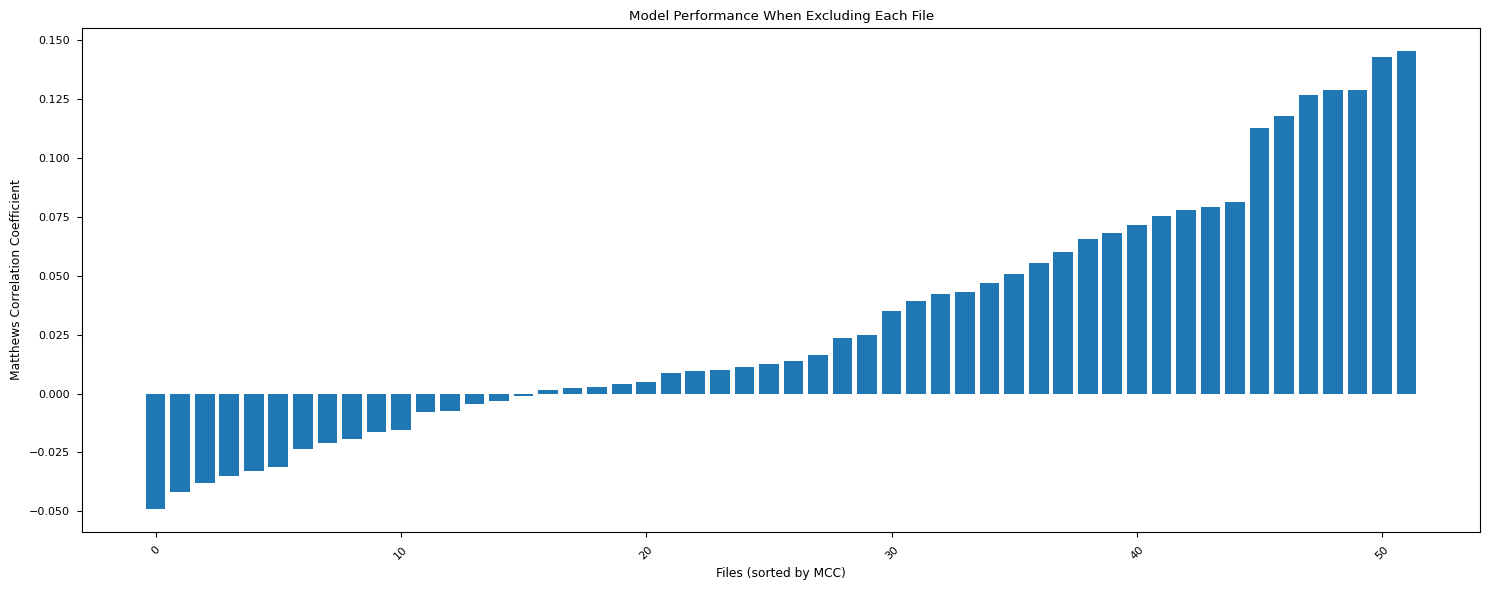


Top 5 most important files (lowest MCC when excluded):
----------------------------------------------------

File: POS_15_C0077C8DC4D3_2024-05-10T16.26.00+02.00_3__annotated_class_all.csv
Accuracy:  0.024957
Precision: 0.040586
Recall:    0.024957
F1:        0.029001
MCC:       -0.049005

File: POS_03_F32F1EAC1A03_2024-05-13T16.08.00+02.00_3__annotated_class_all.csv
Accuracy:  0.047059
Precision: 0.042152
Recall:    0.047059
F1:        0.029459
MCC:       -0.042008

File: POS_05_C93786F37B57_2024-05-08T23.17.00+02.00_2__annotated_class_all.csv
Accuracy:  0.048708
Precision: 0.089950
Recall:    0.048708
F1:        0.044287
MCC:       -0.038075

File: POS_19_FC2172B97EA8_2024-05-11T07.34.00+02.00_2__annotated_class_all.csv
Accuracy:  0.037981
Precision: 0.061931
Recall:    0.037981
F1:        0.033396
MCC:       -0.034897

File: POS_07_E11D6666ED17_2024-05-02T21.49.00+02.00_2__annotated_class_all.csv
Accuracy:  0.054434
Precision: 0.048941
Recall:    0.054434
F1:        0.047069
MCC:   

In [8]:
# Get all CSV files
all_files = os.listdir('data/train')    
csv_files = list(filter(lambda f: f.endswith('.csv'), all_files))

# Run the leave-one-out analysis
results = run_leave_one_out_analysis(light=True)  # Use light=True for faster training

# Analyze the results
df_importance = analyze_results(results)